In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.patches as patches
from functools import partial
import gzip, pickle, copy, random
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import cv2
%matplotlib inline

# Set constants

In [2]:
MAX_DIMS_AMATEUR = (112, 112)
MAX_DIMS_EXPERT = (731, 956)
MAX_DIMS_TEST = (732, 1007)

# Load data

In [3]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object
    
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [4]:
%%time
train_data = load_zipped_pickle("data/train.pkl")

CPU times: user 8.98 s, sys: 2.17 s, total: 11.2 s
Wall time: 12.8 s


In [5]:
%%time
test_data = load_zipped_pickle("data/test.pkl")

CPU times: user 5.95 s, sys: 961 ms, total: 6.91 s
Wall time: 7.96 s


# Define and test helper functions

In [27]:
def get_meta_data(data, train=True):
    idx_expert = []
    idx_amateur = []
    n_labeled = []
    n_frames = []
    frame_height = []
    frame_width = []
    dataset = []
    names = []

    for i, sample in enumerate(data):
        frame_width.append(sample['video'].shape[1])
        frame_height.append(sample['video'].shape[0])
        names.append(sample['name'])
        
        if train:
            if sample['dataset'] == 'amateur':
                idx_amateur.append(i)
            else:
                idx_expert.append(i)
    
            n_labeled.append(len(sample['frames']))
            n_frames.append(sample['video'].shape[2])
            dataset.append(sample['dataset'])
            box = sample['box']
            

    if train:
        df_meta = pd.DataFrame({
            'name': names,
            'n_labeled': n_labeled,
            'n_frames': n_frames,
            'frame_height': frame_height,
            'frame_width':frame_width,
            'dataset': dataset
        })  
    else:
        df_meta = pd.DataFrame({
            'name': names,
            'frame_height': frame_height,
            'frame_width':frame_width
        })
    
    return idx_amateur, idx_expert, df_meta

In [29]:
idx_amateur_train, idx_expert_train, df_meta_train = get_meta_data(train_data, train=True)
_, _, df_meta_test = get_meta_data(test_data, train=False)

In [8]:
def pad_data(data, target_dims, train=True):
    data_pad = []
    for i, sample in tqdm(enumerate(data), total= len(data)):
        video = sample['video']
        if train:
            box = sample['box']
            labels = sample['label']
        
        source_dims = video.shape[:2]
        diff_x = target_dims[1] - source_dims[1]
        diff_y = target_dims[0] - source_dims[0]
        
        top =  int(diff_y // 2)
        bottom = int(diff_y - top)
        
        left = int(diff_x // 2)
        right = int(diff_x - left)
        
        video_pad = []
        for j in range(video.shape[2]):
            frame = video[..., j]
            f_pad = np.pad(frame, ((top, bottom), (left, right)), constant_values=0)
            video_pad.append(f_pad)
        video_pad = np.stack(video_pad, axis=2)
        
        if train:
            labels_pad = []
            for j in range(labels.shape[2]):
                label = labels[..., j]
                l_pad = np.pad(label, ((top, bottom), (left, right)), constant_values=0)
                labels_pad.append(l_pad)
            labels_pad = np.stack(labels_pad, axis=2)
            box_pad = np.pad(box, ((top, bottom), (left, right)), constant_values=0)
            sample_pad = {'name': sample['name'],
                          'video': video_pad,
                          'box': box_pad,
                          'label': labels_pad,
                          'frames': sample['frames'],
                          'dataset': sample['dataset']
                         }
        else:
            sample_pad = {'name': sample['name'],
                          'video': video_pad,
                         }
        
        
        
        data_pad.append(sample_pad)
    return data_pad

In [ ]:
expert_data = [train_data[i] for i in idx_expert]
expert_padded = pad_data(expert_data, MAX_DIMS_EXPERT)

100%|██████████| 19/19 [00:38<00:00,  2.04s/it]


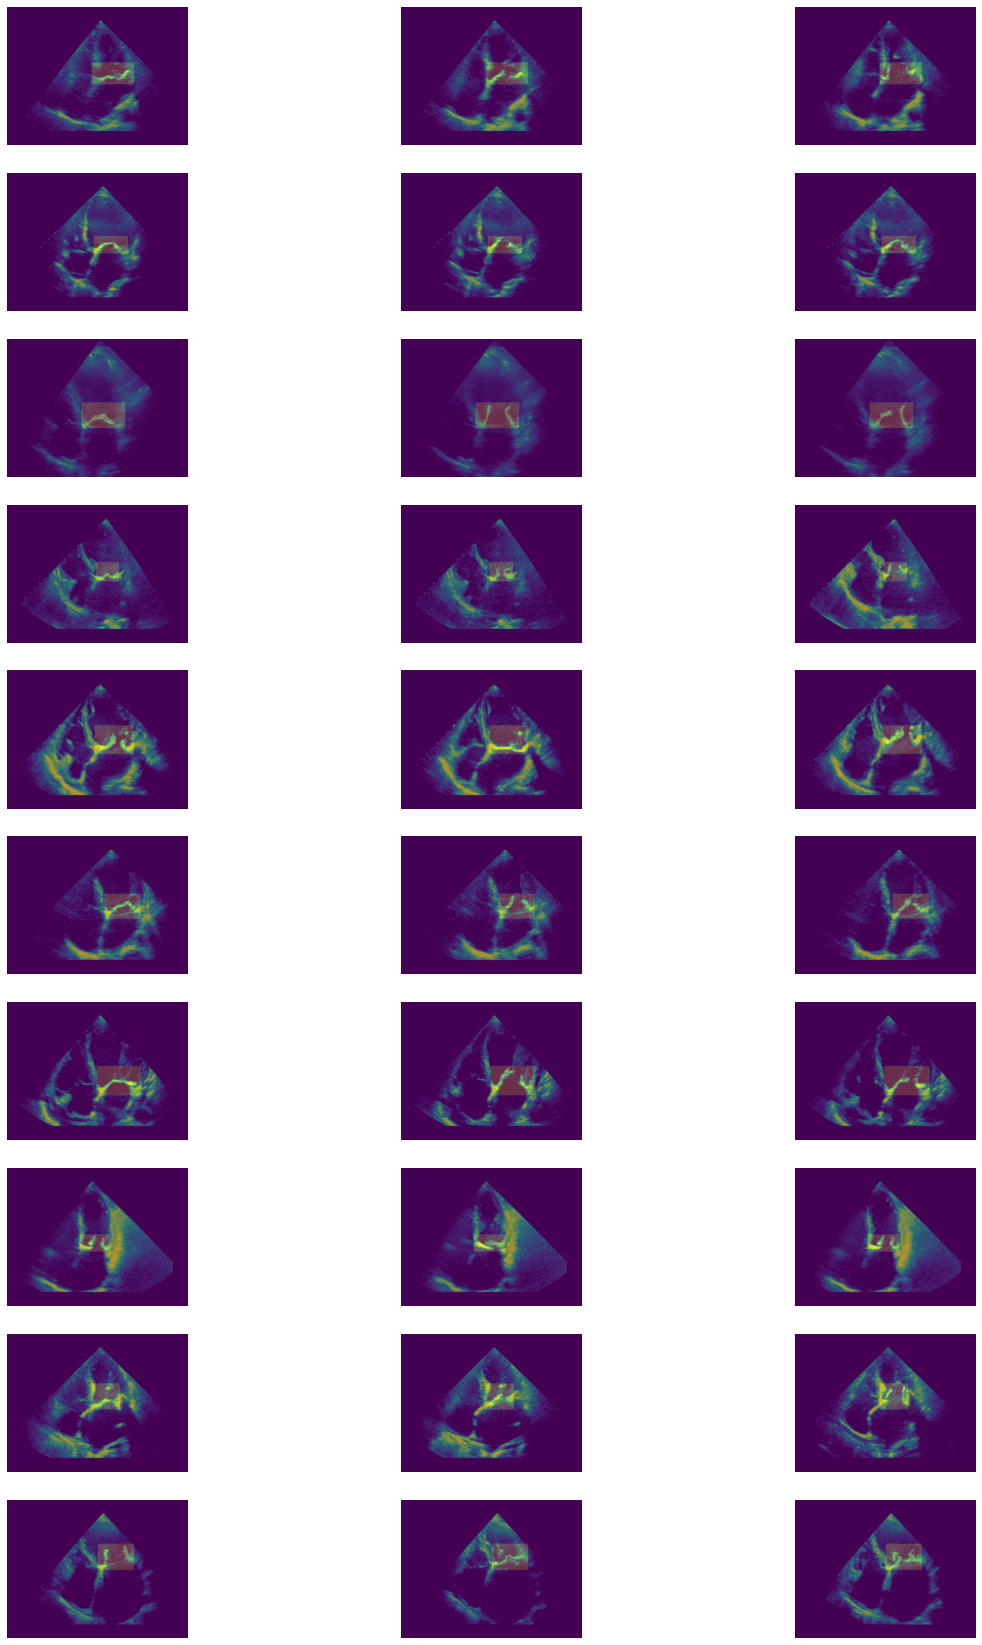

In [10]:
# Test padding
nrows = 10
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 30))
axes = axes.flatten()

for i in range(nrows):
    sample = expert_padded[i]
    frames = sample['frames']
    video = sample['video']
    labels = sample['label']
    box = sample['box']
    
    for j, f in enumerate(frames):
        ax = axes[i * ncols + j]
        img = video[..., f]
        ax.imshow(img)
        ax.imshow(labels[..., f], alpha=0.2)
        ax.imshow(box, alpha = 0.2)
        ax.axis('off')

In [11]:
class Window:
    def __init__(self, x0, y0, width, height):
        self.x = x0
        self.y = y0
        self.width = width
        self.height = height
        
    def crop(self, img):
        assert self.x + self.width < img.shape[1], f"x0 {self.x}, width {self.width}, img_width: {img.shape[1]}"
        assert self.y + self.height < img.shape[0], f"y0 {self.y}, height {self.height}, img_height: {img.shape[0]}"
        
        return img[
            self.y : self.y + self.height,
            self.x : self.x + self.width
        ]
    
    def to_mask(self, mask_dims):
        mask = np.zeros(mask_dims)
        mask[...] = False
        mask[self.y : self.y + self.height, self.x : self.x + self.width] = True
        return mask
        

In [12]:
def plot_window(w, ax):
    
    ax.add_patch(
         patches.Rectangle(
            (w.x, w.y),
            w.width,
            w.height,
            edgecolor = 'white',
            facecolor = 'red',
            fill=False
         )
    )
    return ax

<AxesSubplot:>

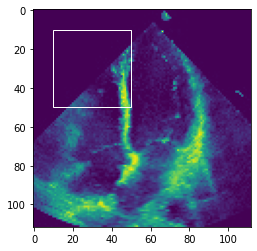

In [13]:
# Test plot window
w = Window(10, 10, 40, 40)
fig, ax = plt.subplots()
ax.imshow(train_data[0]['video'][..., 0])
plot_window(w, ax)

In [14]:
# generate windows
def generate_windows(img_dims=(112, 112), grid=5, w_dims=(20, 30)):
    w_height, w_width = w_dims
    img_height, img_width = img_dims

    windows = []
    
    # TODO: use heatmap as prior instead of offsets
    #offset_x = img_width // 2 - grid * 3
    #offset_y = 20

    for j in range(0, img_height, grid):
        for i in range(0, img_width, grid):
            if img_width < i + w_width:
                continue
            if img_height < j + w_height:
                continue

            windows.append(Window(i, j, w_width, w_height))
    return windows

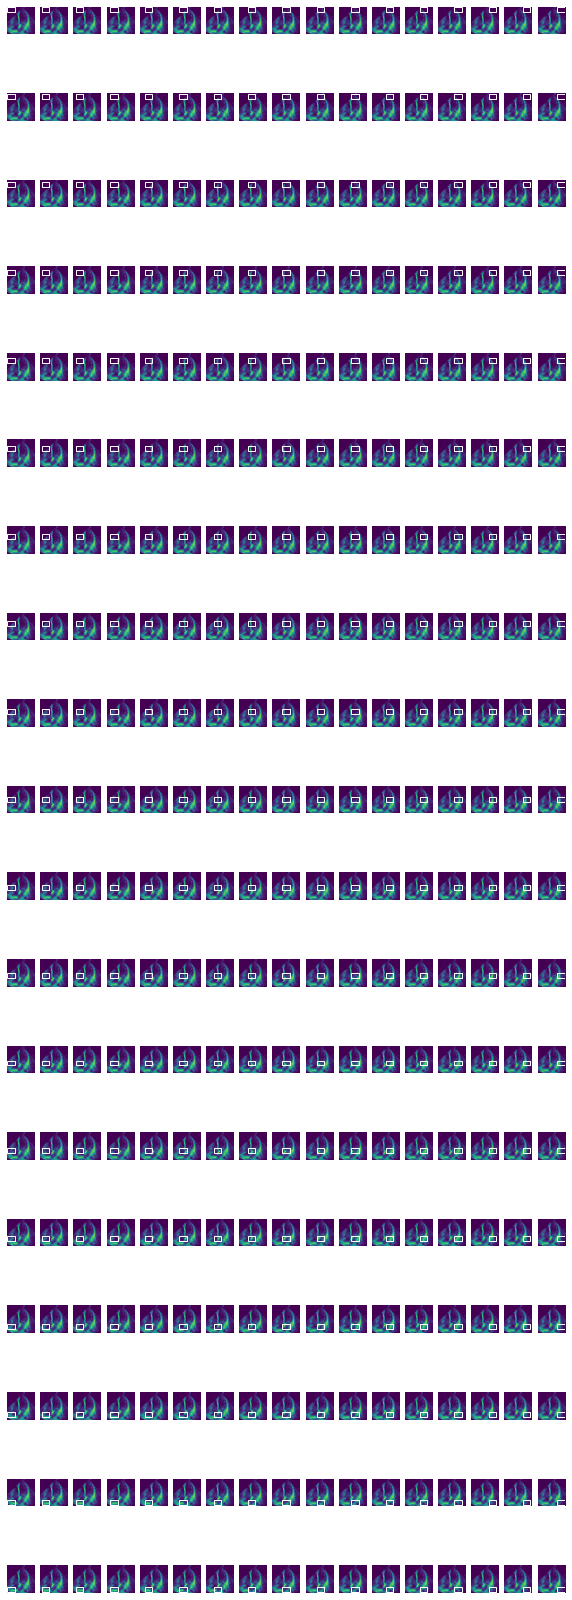

In [15]:
# Test window generation
windows = generate_windows()

ncols = 17
nrows = len(windows) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 30))
axes = axes.flatten()

sample_frame = train_data[0]['video'][..., 0]

windows = generate_windows()

for i, w in enumerate(windows):
    axes[i].imshow(sample_frame)
    plot_window(w, axes[i])
    axes[i].axis('off')

(600,)

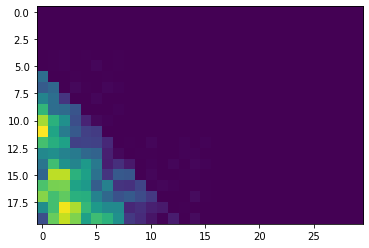

In [16]:
# Test cropping
cropped_frame = windows[84].crop(sample_frame)
plt.imshow(cropped_frame)
cropped_frame.flatten().shape

In [17]:
# According to Automatic Mitral Leaflet Tracking in Echocardiography
# by Outlier Detection in the Low-rank Representation
# Followint Algorithm 1

def spectral_norm(video, windows, k=5):
    eps = []
    scaler = StandardScaler()
    scaler.fit(video[..., 0])

    for w in windows:
        M = []
        for i in range(video.shape[2]):
            frame = video[..., i]
            
            #frame = scaler.transform(frame)
            
            m = w.crop(frame).flatten()
            M.append(m)
        M = np.stack(M, axis=1)
        s = np.linalg.svd(M, compute_uv=False)
        e = np.sum(np.square(s[k:]))
        eps.append(e)
    return np.array(eps)

In [18]:
def gen_heatmap(data, show=False):
    boxes = []
    for sample in data:
        box = sample['box']
        boxes.append(box)
        
    boxes = np.stack(boxes, axis=0)
    heat_map = np.mean(boxes, axis=0)
    if show:
        plt.imshow(heat_map)
        plt.axis('off')
    return heat_map

In [19]:
def heatmap_norm(data, windows, heatmap):
    norms = []
    for w in windows:
        h = w.crop(heatmap).flatten()
        norms.append(np.sum(np.square(h)))
    return np.array(norms)

In [20]:
def predict_window(norms, weights, windows):
    assert len(norms) == len(weights)
    norms_scaled = []
    for n in norms:
        n_scaled = MinMaxScaler().fit_transform(n.reshape(-1, 1))
        norms_scaled.append(n_scaled)
    
    n_combined = 0
    for n, w in zip(norms_scaled, weights):
        n_combined += w * n

    l_star = np.argmax(n_combined)
    w_star = windows[l_star]

    return w_star

In [21]:
# Predict and plot rois
def plot_rois(data, heatmap, ncols=3, grid=30, w_dims=(150, 250), img_dims=MAX_DIMS_TEST, weights=[1, 0.5], train=True):
    nrows = len(data)
    fig, axes = plt.subplots(nrows, ncols, figsize=(5, 60))
    axes = axes.flatten()

    windows = generate_windows(img_dims=img_dims, grid=grid, w_dims=w_dims)    
    w_stars = []
    heat_norm = heatmap_norm(data, windows, heatmap)

    for i in tqdm(range(len(data))):

        sample = copy.deepcopy(data[i])
        video = sample['video']
        
        if train:
            frames = sample['frames']
            labels = sample['label']
        else:
            frames = random.sample(range(video.shape[2]), ncols)


        s_norm = spectral_norm(video, windows)
        w_star = predict_window([s_norm, heat_norm], weights, windows)
        w_stars.append(w_star)

        for j, f in enumerate(frames):
            idx_plot = i* len(frames) + j
            if train:
                axes[idx_plot].imshow(labels[..., f])
            else:
                axes[idx_plot].imshow(video[..., f])
            plot_window(w_star, axes[idx_plot])
            axes[idx_plot].axis('off')
    return w_stars

# Predict rois

The spectral norm contains information of how much information is stored in a specific matrix. We use this property to detect heavy movement between frames and compute a selection of candidate windows for the region of interest. We further use boxes from the training data to compute a probability heatmap where the roi usually is. This heatmap serves as a kind of prior and is combined with the spectral norm to selct a single roi prediction.

100%|██████████| 46/46 [03:08<00:00,  4.10s/it]


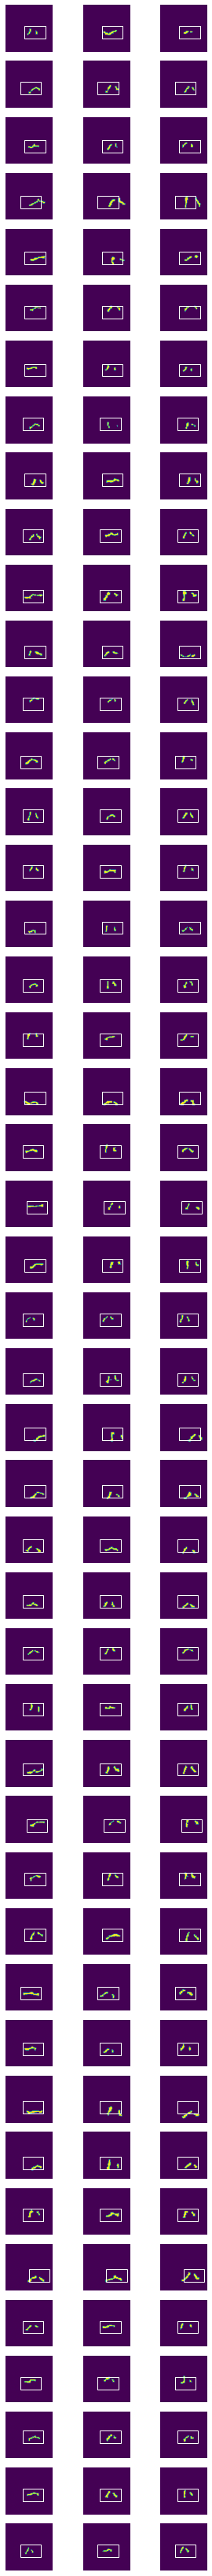

In [22]:
# Predict roi for amateur data
data_amateur = [train_data[i] for i in idx_amateur]
heatmap = gen_heatmap(data_amateur)
windows_amateur = plot_rois(data_amateur, heatmap, grid=5, w_dims=(30, 50), img_dims=MAX_DIMS_AMATEUR)

100%|██████████| 19/19 [43:15<00:00, 136.63s/it] 


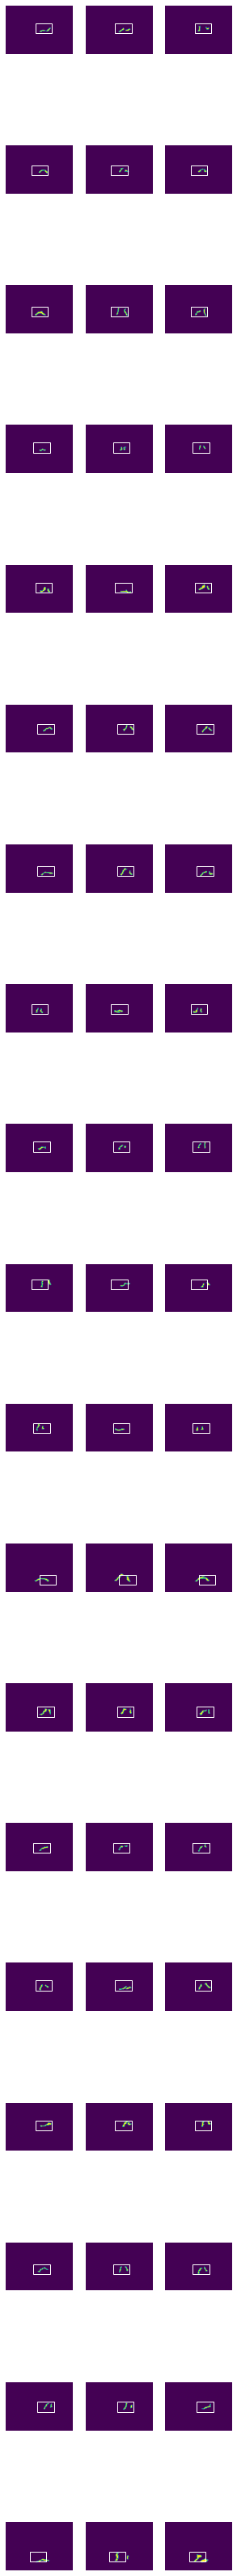

In [23]:
# Predict roi for expert train data
data_expert = [train_data[i] for i in idx_expert]
expert_train_padded = pad_data(data_expert, MAX_DIMS_TEST)
heatmap = gen_heatmap(expert_train_padded)
windows_expert_train = plot_rois(expert_train_padded, heatmap)

100%|██████████| 20/20 [48:56<00:00, 146.81s/it]


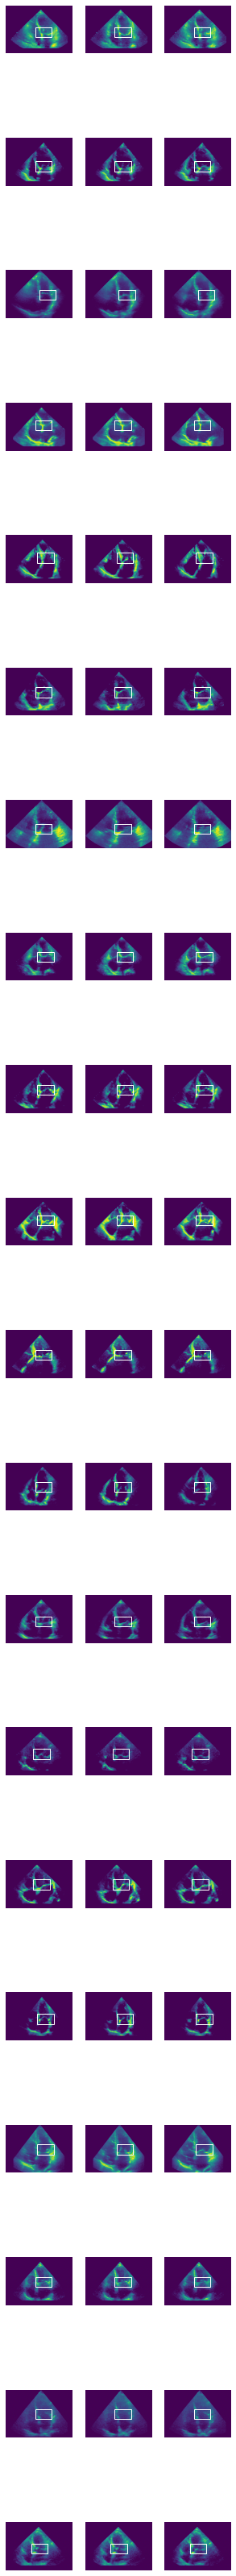

In [24]:
# Predict roi for expert test data
heatmap = gen_heatmap(expert_train_padded)
expert_test_padded = pad_data(test_data, MAX_DIMS_TEST, train=False)
windows_expert_test = plot_rois(expert_test_padded, heatmap, train=False)

In [30]:
# Store roi meta data
roi_dims_test = [(w.height, w.width) for w in windows_expert_test]
#roi_dims_train = [(w.height, w.width) for w in windows_expert_train]

roi_coord_test = [(w.x, w.y) for w in windows_expert_test]
#roi_coord_train = [(w.x, w.y) for w in windows_expert_train]

df_meta_test['roi_coord'] = roi_coord_test
df_meta_test['roi_dims'] = roi_dims_test

#df_meta_train['roi_coord'] = roi_coord_train
#df_meta_train['roi_dims'] = roi_dims_train

df_meta_test.to_csv('data/lookup_test.csv')

In [31]:
df_meta_test

,name,frame_height,frame_width,roi_coord,roi_dims
0,RZ9W7OK2EO,583,863,"(450, 330)","(150, 250)"
1,401JD35E1A,582,737,"(450, 360)","(150, 250)"
2,O7WUJ71C15,732,845,"(510, 300)","(150, 250)"
3,7UXIXUBK2G,587,781,"(450, 270)","(150, 250)"
4,JQX264DTZ0,587,773,"(480, 270)","(150, 250)"
5,NHC30J31YN,583,784,"(450, 300)","(150, 250)"
6,CD4RIAOCHG,731,1007,"(450, 360)","(150, 250)"
7,QJTAVYCG6M,583,707,"(480, 300)","(150, 250)"
8,3WOQKZBVRN,583,782,"(480, 300)","(150, 250)"
9,UB7LFQKZT5,583,779,"(480, 270)","(150, 250)"


In [150]:
def upscale(frame, img_dims, roi_coord, roi_dims):
    img_height, img_width = img_dims
    roi_height, roi_width = roi_dims

    # Remove offset from padding
    height_padded, width_padded = (732, 1007)
    offset_y = (height_padded - img_height) // 2
    offset_x = (width_padded - img_width) // 2

    x, y = roi_coord
    x -= offset_x
    y -= offset_y
    
    #x -= 30
    
    top = y
    bottom = img_height - y - roi_height
    
    left = x
    right = img_width - x - roi_width
    
    #if bottom < 0:
    #    frame = frame[:bottom, :]
    #    bottom = 0
    #if right < 0:
    #    frame = frame[:, :right]
    #    right = 0
    
    f_pad = np.pad(frame, ((top, bottom), (left, right)), constant_values=0)
    return f_pad

In [146]:
MAX_DIMS_EXPERT

(731, 956)

In [174]:
for i in range(19):
    sample = expert_test_padded[i]
    name = sample['name']
    frame_padded = sample['video'][..., 0]
    frame = test_data[i]['video'][..., 0]
    w_cropped = windows_expert_test[i].crop(frame_padded)
    print(w_cropped.shape)

(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)
(150, 250)


(732, 1007)


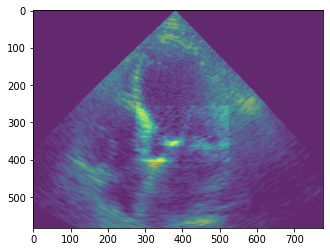

In [172]:
# Test upscale
i = 19
sample = expert_test_padded[i]
name = sample['name']
frame_padded = sample['video'][..., 0]
print(frame_padded.shape)
frame = test_data[i]['video'][..., 0]
w_cropped = windows_expert_test[i].crop(frame_padded)
sample_meta = df_meta_test[df_meta_test.name == name]
img_dims = (sample_meta.frame_height.values[0], sample_meta.frame_width.values[0])

roi_coord = (sample_meta.roi_coord).values[0]
roi_dims = (sample_meta.roi_dims).values[0]


w_padded = upscale(w_cropped, img_dims, roi_coord, roi_dims)
fig, ax = plt.subplots(1, 1)
ax.imshow(w_padded, alpha=0.6)
ax.imshow(frame, alpha=0.6)
#ax.imshow(frame_padded, alpha=0.5)

#plot_window(windows_expert_test[i], ax)

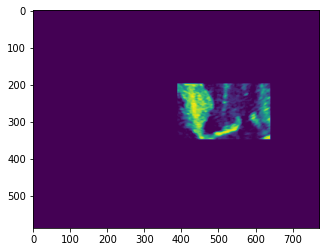

In [143]:
plt.imshow(w_padded)

In [95]:
# convert window to boolean mask
roi_expert_train = [w.to_mask(MAX_DIMS_TEST) for w in windows_expert_train]
roi_expert_test = [w.to_mask(MAX_DIMS_TEST) for w in windows_expert_test]
roi_amateur = [w.to_mask(MAX_DIMS_AMATEUR) for w in windows_amateur]

In [97]:
# add roi predictions to padded data
for i, roi in enumerate(roi_expert_train):
    expert_train_padded[i]['roi'] = roi
    
for i, roi in enumerate(roi_expert_test):
    expert_test_padded[i]['roi'] = roi
    
for i, roi in enumerate(roi_amateur):
    data_amateur[i]['roi'] = roi

In [104]:
# Save padded data as pkl

In [106]:
%%time
save_zipped_pickle(expert_train_padded, 'data/expert_train_padded.pkl')

In [108]:
# Sanity check stored data
sanity_check_data = load_zipped_pickle('data/expert_train_padded.pkl')
sanity_check_data[0].keys()

dict_keys(['name', 'video', 'box', 'label', 'frames', 'dataset', 'roi'])

In [109]:
%%time
save_zipped_pickle(expert_test_padded, 'data/expert_test_padded.pkl')

CPU times: user 1min 53s, sys: 6.14 s, total: 1min 59s
Wall time: 2min 15s


In [113]:
%%time
save_zipped_pickle(data_amateur, 'data/amateur_train.pkl')

CPU times: user 23.2 s, sys: 611 ms, total: 23.8 s
Wall time: 24.6 s
